In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [7]:
data_root = "data/train/synth"
csv_files = glob.glob(os.path.join(data_root, "**", "rt60.csv"), recursive=True)
csv_files

['data/train/synth/leo_2/rt60.csv',
 'data/train/synth/leo_4/rt60.csv',
 'data/train/synth/jojo_3_cirlce/rt60.csv',
 'data/train/synth/jojo_4_unsorted/rt60.csv',
 'data/train/synth/jojo_5_unsorted/rt60.csv',
 'data/train/synth/leo_10/rt60.csv',
 'data/train/synth/leo_8/rt60.csv',
 'data/train/synth/jojo_9_unsorted/rt60.csv',
 'data/train/synth/leo_6/rt60.csv',
 'data/train/synth/leo_5/rt60.csv',
 'data/train/synth/leo_9/rt60.csv',
 'data/train/synth/leo_3/rt60.csv',
 'data/train/synth/jojo_2_sorted/rt60.csv',
 'data/train/synth/jojo_1_unsorted/rt60.csv']

In [8]:
room_data = []
for csv_file in csv_files:
    room_name = os.path.split(csv_file)[0].split(os.sep)[-2]
    df = pd.read_csv(csv_file)
    df["Room"] = room_name
    room_data.append(df)

data = pd.concat(room_data, ignore_index=True)
data = data[data["Frequency (Hz)"] >= 250]
data.head(10)

,Frequency (Hz),RT60 (s),Room
5,250,3.585055,synth
6,500,3.065953,synth
7,1000,2.892610,synth
8,2000,2.696130,synth
9,4000,2.212865,synth
10,8000,1.794288,synth
16,250,3.348896,synth
17,500,3.152314,synth
18,1000,3.115426,synth
19,2000,3.078538,synth


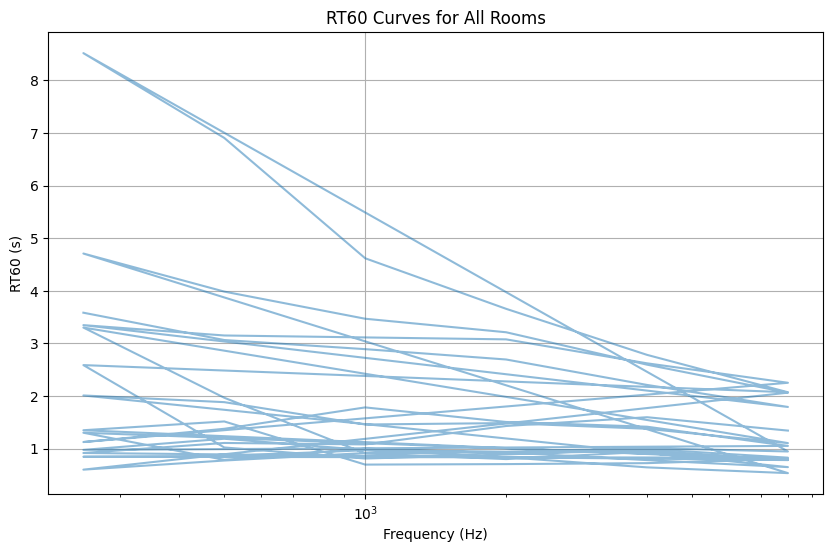

In [9]:
plt.figure(figsize=(10, 6))
for room, group in data.groupby("Room"):
    plt.plot(group["Frequency (Hz)"], group["RT60 (s)"], alpha=0.5, label=room)

plt.xscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("RT60 (s)")
plt.title("RT60 Curves for All Rooms")
plt.grid(True)
plt.show()

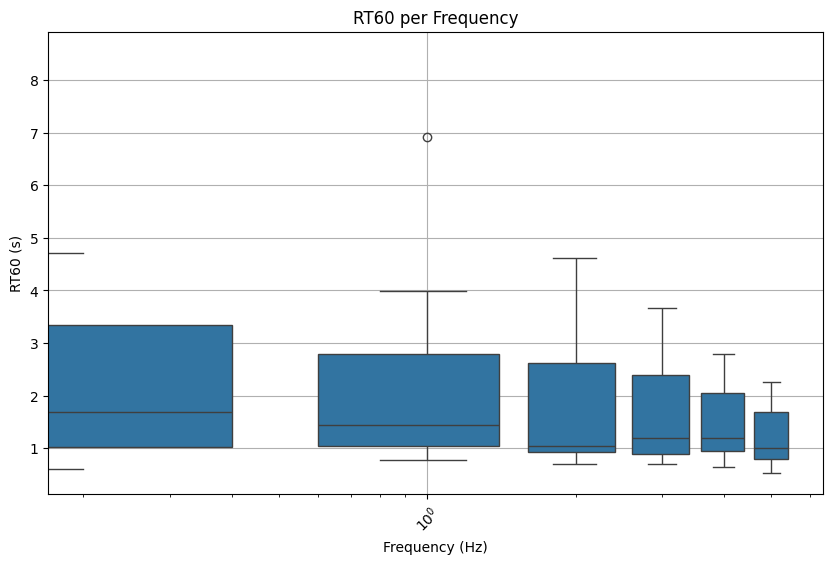

In [10]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x="Frequency (Hz)", y="RT60 (s)", data=data)
plt.xscale("log")
plt.xticks(rotation=45)
plt.title("RT60 per Frequency")
plt.grid(True)
plt.show()

/tmp/ipykernel_5873/2472099893.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_z = data.groupby("Frequency (Hz)", group_keys=False).apply(mark_outliers)


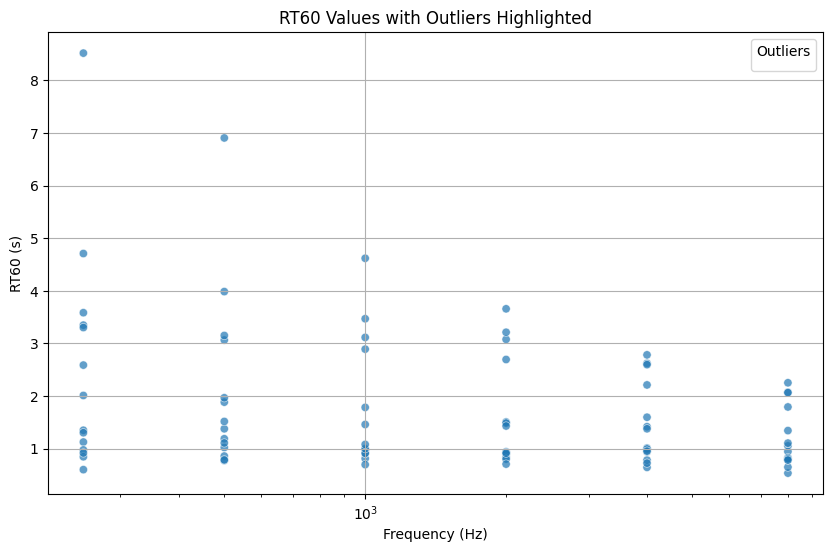

🔍 Found 0 outlier points across 0 rooms.


In [11]:
from scipy.stats import zscore

# Compute z-scores per frequency band
def mark_outliers(df):
    df["Z"] = zscore(df["RT60 (s)"])
    df["Outlier"] = df["Z"].abs() > 4
    return df

data_z = data.groupby("Frequency (Hz)", group_keys=False).apply(mark_outliers)

# Plot outliers
outliers = data_z[data_z["Outlier"]]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_z, x="Frequency (Hz)", y="RT60 (s)", hue="Outlier", style="Room", alpha=0.7)
plt.xscale("log")
plt.title("RT60 Values with Outliers Highlighted")
plt.grid(True)
#only show legend for outliers
handles, labels = plt.gca().get_legend_handles_labels()
outlier_handles = [handles[i] for i in range(len(labels)) if labels[i] == "True"]
outlier_labels = [labels[i] for i in range(len(labels)) if labels[i] == "True"]
plt.legend(outlier_handles, outlier_labels, title="Outliers", loc="upper right")

plt.show()

print(f"🔍 Found {len(outliers)} outlier points across {outliers['Room'].nunique()} rooms.")


In [12]:
outlier_summary = outliers.groupby("Room").size().reset_index(name="Outlier Count")
print(outlier_summary.sort_values("Outlier Count", ascending=False))


Empty DataFrame
Columns: [Room, Outlier Count]
Index: []


In [94]:
# all rooms with times over 4 seconds
outliers_over_4s = data[data["RT60 (s)"] > 4]
print(f"🔍 Found {len(outliers_over_4s)} outlier points across {outliers_over_4s['Room'].nunique()} rooms."
      f" {outliers_over_4s["RT60 (s)"].max()}s max RT60.")
outliers_over_4s_summary = outliers_over_4s.groupby("Room").size().reset_index(name="Outlier Count")
print(outliers_over_4s_summary.sort_values("Outlier Count", ascending=False))


🔍 Found 3 outlier points across 3 rooms. 24.57774603808292s max RT60.
        Room  Outlier Count
0   ZW10-2-3              1
1     HO2-86              1
2      ZO9-1              1


In [95]:
# print data of outliers
for room, group in outliers_over_4s.groupby("Room"):
    print(f"Room: {room}")
    print(group[["Frequency (Hz)", "RT60 (s)"]])
    print()

Room:  ZW10-2-3
   Frequency (Hz)   RT60 (s)
9            4000  24.577746

Room: HO2-86
    Frequency (Hz)   RT60 (s)
77           16000  15.070548

Room: ZO9-1
     Frequency (Hz)  RT60 (s)
293            1000  6.055387

